### 1.

In [1]:
import numpy as np


def ab2(h, N, c, g, L, y0):
    f = lambda y: np.array([[0, 1], [-g / L, -c]]) @ y

    y = np.zeros((N + 1, 2))

    y[0] = y0

    for i in range(0, N):
        if i == 0:
            k1 = h * f(y[i])
            k2 = h * f(y[i] + k1 / 2)

            y[i + 1] = y[i] + k2

        else:
            y[i + 1] = y[i] + 3 * h * f(y[i]) / 2 - h * f(y[i - 1]) / 2

    return y.T


def leapfrog(h, N, c, g, L, y0):
    f = lambda y: np.array([[0, 1], [-g / L, -c]]) @ y

    y = np.zeros((N + 1, 2))

    y[0] = y0

    for i in range(0, N):
        if i == 0:
            k1 = h * f(y[i])
            k2 = h * f(y[i] + k1 / 2)

            y[i + 1] = y[i] + k2

        else:
            y[i + 1] = y[i - 1] + 2 * h * f(y[i])

    return y.T


def rk4(h, N, c, g, L, y0):
    f = lambda y: np.array([[0, 1], [-g / L, -c]]) @ y

    y = np.zeros((N + 1, 2))
    y[0] = y0

    for i in range(1, N + 1):
        k1 = h * f(y[i - 1])
        k2 = h * f(y[i - 1] + k1 / 2)
        k3 = h * f(y[i - 1] + k2 / 2)
        k4 = h * f(y[i - 1] + k3)
        y[i] = y[i - 1] + k1 / 6 + (k2 + k3) / 3 + k4 / 6

    return y.T

### 2.

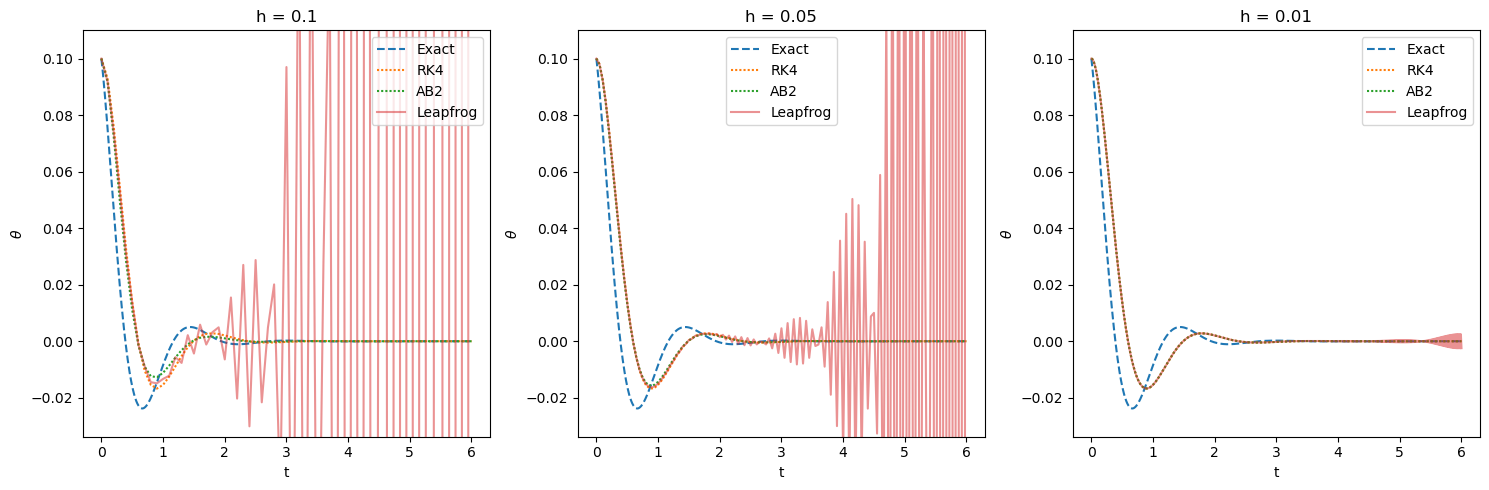

In [119]:
import matplotlib.pyplot as plt

c = 4
g = 9.81
L = 0.6
y0 = np.array([0.1, 0])
hs = np.array([0.1, 0.05, 0.01])
Ns = np.array([int(6 / h) for h in hs])

rk4_results = []
ab2_results = []
leapfrog_results = []

for i in range(hs.shape[0]):
    rk4_results.append(rk4(hs[i], Ns[i], c, g, L, y0))
    ab2_results.append(ab2(hs[i], Ns[i], c, g, L, y0))
    leapfrog_results.append(leapfrog(hs[i], Ns[i], c, g, L, y0))


def exact_soln(t, theta0, c, g, L):
    return theta0 * np.cos(np.sqrt(g / L) * t) * np.exp(-c * t / 2)


t = np.linspace(0, 6, 1000)
theta0 = y0[0]
exact = exact_soln(t, theta0, c, g, L)

fig, axes = plt.subplots(1, hs.shape[0], figsize=(15, 5))

for i in range(hs.shape[0]):
    axes[i].plot(t, exact, label="Exact", linestyle="--")

    axes[i].plot(
        np.linspace(0, 6, Ns[i] + 1),
        rk4_results[i][0],
        label="RK4",
        linestyle=(0, (1, 1)),
    )

    axes[i].plot(
        np.linspace(0, 6, Ns[i] + 1),
        ab2_results[i][0],
        label="AB2",
        linestyle=(0, (1, 1)),
    )

    axes[i].plot(
        np.linspace(0, 6, Ns[i] + 1),
        leapfrog_results[i][0],
        label="Leapfrog",
        alpha=0.5,
    )

    axes[i].set_title("h = {}".format(hs[i]))
    axes[i].legend()
    axes[i].set_ylim(np.min(exact) - 0.01, np.max(exact) + 0.01)
    axes[i].set_xlabel("t")
    axes[i].set_ylabel(r"$\theta$")
fig.tight_layout()
plt.show()

The eigenvalues of the system are found by solving $det(\begin{bmatrix} -\lambda & 1 \\ -g/L & -c - \lambda\end{bmatrix}) = 0$. This results in $\lambda = \frac{1}{2}[c \pm \sqrt{c^{2} - 4g/L}]$. Plugging in $c=4$ and $g=9.81$ and $L=0.6$ gives us $\lambda = -2 \pm \frac{i}{2}\sqrt{49.4}$. We can then use the appropriate formula for the amplification factors of each method to assess its stability.

RK4:

The amplification factor is given by $1 + \lambda h + \frac{\lambda^{2} h^{2}}{2} + \frac{\lambda^{3}h^{3}}{6} + \frac{\lambda^{4}h^{4}}{24}$

In [114]:
lam = -4 + complex(0, np.sqrt(49.4))
lam /= 2
sigma = (
    1
    + lam * hs
    + lam**2 * hs**2 / 2
    + lam**3 * hs**3 / 6
    + lam**4 * hs**4 / 24
)

print("for h = {}:".format(hs), "\n|sigma| = {}".format(np.round(np.abs(sigma), 3)))

for h = [0.1  0.05 0.01]: 
|sigma| = [0.819 0.905 0.98 ]


Thus, RK4 is stable for each time step chosen. Further, we expect to see phase lead for this method. The amplitude error should not change much between the given time step sizes.

Leap Frog:

The amplication factor is given by $\sigma_{1,2} = \lambda h \pm \sqrt{\lambda^{2}h^{2} + 1}$. We require $|\sigma_{1}| \leq 1$ and $|\sigma_{2}| \leq 1$ for stability.

In [121]:
sigma1 = hs * lam + np.sqrt(lam**2 * hs + 1)
sigma2 = hs * lam - np.sqrt(lam**2 * hs + 1)

print(
    "for h = {}:".format(hs),
    "\n|sigma1| = {}".format(np.round(np.abs(sigma1), 3)),
    "\n|sigma2| = {}".format(np.round(np.abs(sigma2), 3)),
)

for h = [0.1  0.05 0.01]: 
|sigma1| = [0.817 0.799 0.941] 
|sigma2| = [1.578 1.127 0.986]


Thus, due to the spurious root being greater than $1$ for $h = 0.1$ and $h = 0.05$, the leapfrog method is unstable for these time steps. For $h = .01$, the spurious root is close enough to $1$ that the method will become unstable for large $t$, but is stable early on. Further reduction in $h$ will result in stability.

AB2:

The amplication factor is given by $\sigma_{1} = 1 + \lambda h + \frac{\lambda^{2}h^{2}}{2} + O(h^{3})$ and $\sigma_{2} = \frac{\lambda h}{2} - \frac{\lambda^{2}h^{2}}{2} + O(h^{3})$. We require $|\sigma_{1,2}| \leq 1$ for stability.

In [120]:
sigma1 = 1 + lam * hs + lam**2 * hs**2 / 2
sigma2 = lam * hs / 2 - lam**2 * hs**2 / 2

print(
    "for h = {}:".format(hs),
    "\n|sigma1| = {}".format(np.round(np.abs(sigma1), 3)),
    "\n|sigma2| = {}".format(np.round(np.abs(sigma2), 3)),
)

for h = [0.1  0.05 0.01]: 
|sigma1| = [0.809 0.904 0.98 ] 
|sigma2| = [0.253 0.113 0.021]


Thus, the AB2 method is stable for each time step chosen.

### 3.

The AB2 method is derived from the Taylor expansion of $y_{n+1}$:

$y_{n+1} = y_{n} + hy'_{n} + \frac{h^{2}}{2}y''_{n} + \frac{h^{3}}{6}y'''_{n} + ...$

We arrive at the AB2 form by letting $y'_{n} = f(y_{n}, t_{n})$ and using the backwards difference formula to approximate $y''_{n} \approx \frac{y'_{n} - y'_{n-1}}{h} = \frac{f(y_{n}, t_{n}) - f(y_{n-1}, t_{n-1})}{h}$.

Substituting this into the Taylor expansion gives us:

$y_{n+1} = y_{n} + \frac{3h}{2}f(y_{n}, t_{n}) - \frac{h}{2}f(y_{n-1}, t_{n-1}) + \frac{h^{3}}{6}y'''_{n} + ...$

The first three terms of this series are the AB2 method. The last term, $\frac{h^{3}}{6}y'''_{n}$ , is the leading local truncation error term. Thus, the AB2 is locally third order accurate and globally second order accurate.

### 4.

### 5a.

The maximum step size is given by $-10h = \frac{-6}{11} \rightarrow h_{max} = \frac{6}{110} \approx .05$

### 5b.

The maximum step size is given by $4h = \frac{12}{5\sqrt{11}} \rightarrow h_{max} = \frac{3}{5\sqrt{11}} \approx .18$

### 5c.

The maximum step size is given by $|\lambda|h = r_{max}$ where $r_{max} \in [\frac{6}{11}, \frac{12}{5\sqrt{11}}]$ and $|\lambda| = \sqrt{5}$. Taking the most conservative estimate of $r_{max} = \frac{6}{11}$, we get $h_{max} = \frac{6}{11\sqrt{5}} \approx .24$

### 6a.

$f(t, y) = y' = e^{sin(y)} - ty$

$y_{n+1} \approx y_{n} + \frac{h}{2}[f(y_{n}, t_{n}) + f(y_{n+1}, t_{n+1})]$

$F(y_{n+1}) = y_{n} + \frac{h}{2}[f(y_{n}, t_{n}) + f(y_{n+1}, t_{n+1})] - y_{n+1} = 0$

$F(y_{n+1}) = y_{n} + \frac{h}{2}[e^{sin(y_{n})} + e^{sin(y_{n+1})} - t_{n}y_{n} - t_{n+1}y_{n+1}] - y_{n+1} = 0$

### 6b.

$DF(y_{n+1}) = \frac{\partial F}{\partial y_{n+1}}$

$DF(y_{n+1}) = \frac{h}{2}[e^{sin(y_{n+1})}\cdot cos(y_{n+1}) - t_{n+1}] - 1$

### 6c.

```
for n in range(N):

    k = 0
    while k < max_iter:
```

$\qquad \> \qquad \> y_{n+1}^{k+1} = y_{n+1}^{k} - \frac{F(y_{n}, t_{n}, y_{n+1}^{k}, t_{n+1})}{DF(y_{n+1}^{k}, t_{n+1})}$

```
        k += 1
```


### 6d.

In [122]:
def trapezoid(h, N, y0, tol, max_iter):
    f = lambda y, t: np.exp(np.sin(y)) - t * y

    def F(y0, t0, y1, t1):
        return y0 - y1 + h * (f(y0, t0) + f(y1, t1)) / 2

    def dF(y1, t1):
        return -1 + h * (np.exp(np.sin(y1)) * np.cos(y1) - t1) / 2

    y = np.zeros(N + 1)
    y[0] = y0
    ts = np.arange(N + 1) * h

    for i in range(1, N + 1):
        y0 = y[i - 1]
        t0 = ts[i - 1]
        # List of yn+1 iterations
        # start with the guess being the last y
        y1 = [y0]
        t1 = ts[i]

        ii = 0
        while ii <= max_iter:
            s = -F(y0, t0, y1[ii], t1) / dF(y1[ii], t1)
            y1.append(y1[ii] + s)
            ii += 1

            if np.abs(F(y0, t0, y1[ii], t1)) < tol:
                break

        y[i] = y1[-1]

    return y

### 6e.

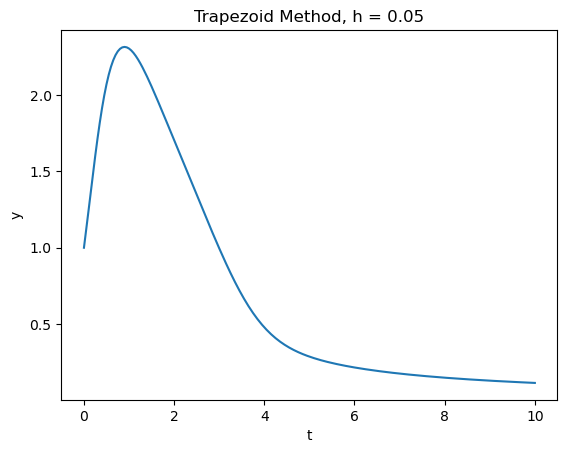

In [128]:
h = 0.05
N = int(10 / h)
y0 = 1
tol = 1e-12
max_iter = np.inf
t = np.arange(N + 1) * h
y = trapezoid(h, N, y0, tol, max_iter)

plt.plot(t, y)
plt.xlabel("t")
plt.ylabel("y")
plt.title("Trapezoid Method, h = 0.05")
plt.show()